```mermaid
flowchart LR

classDef notebook fill:#5c7fa6,stroke:#3f5a7b,color:#f2f6fb, font-weight:bold;
classDef python fill:#9a80b8,stroke:#6d5789,color:#f7f3fb, font-weight:bold;
classDef tools fill:#e9c48a,stroke:#b58950,color:#2d1c05;
classDef methods fill:#8cc7ab,stroke:#5e9475,color:#0f2f1f;

N05B["06_composites.ipynb"]:::notebook

N05B --> C1["composite_generator.py"]:::python

C1 --> T6["Tools:<br>polars (optional)<br>numpy<br>Pillow<br>os<br>random"]:::tools

T6 --> M6["Methods:<br>filter_images()<br>make_composite()<br>filter_faces()<br>generate_composite()"]:::methods


In [1]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


In [2]:
import pandas as pd

ATTR_PATH = 'data/processed/metadata/attributes_final.parquet'
ATTR_SCORES = 'data/processed/metadata/attractiveness_scores.parquet'
ATTR_META = 'data/processed/metadata/attributes_with_meta.parquet'

attributes_final = pd.read_parquet(ATTR_PATH)

# Merge model attractiveness scores
try:
    df_scores = pd.read_parquet(ATTR_SCORES)
    attributes_final = attributes_final.merge(
        df_scores[['filename', 'attractiveness']],
        on='filename',
        how='left',
        suffixes=('', '_model')
    )
    if 'attractiveness_model' in attributes_final.columns:
        if 'attractiveness' in attributes_final.columns:
            attributes_final['attractiveness'] = attributes_final['attractiveness'].fillna(
                attributes_final['attractiveness_model']
            )
        else:
            attributes_final['attractiveness'] = attributes_final['attractiveness_model']
        attributes_final = attributes_final.drop(columns=['attractiveness_model'])
except FileNotFoundError:
    print(f'Missing {ATTR_SCORES}; run attractiveness inference first.')

# Optional geometry-based attractiveness
try:
    df_meta = pd.read_parquet(ATTR_META)
    if 'attractiveness_geom' in df_meta.columns:
        attributes_final = attributes_final.merge(df_meta[['filename','attractiveness_geom']], on='filename', how='left')
except FileNotFoundError:
    pass

attributes_final.head()


,filename,age,gender_final,ethnicity_final,attractiveness,attractiveness_geom
0,SFHQ_pt4_00086092.jpg,None,unknown,unknown,8,6.0
1,SFHQ_pt4_00065309.jpg,None,female,unknown,7,6.0
2,SFHQ_pt4_00062466.jpg,None,unknown,unknown,2,9.0
3,SFHQ_pt4_00090828.jpg,None,unknown,unknown,4,9.0
4,SFHQ_pt4_00032251.jpg,None,unknown,unknown,5,4.0


#### Optional: filter by geometry-based attractiveness

In [3]:

# Example filter by model attractiveness (continuous)
if 'attractiveness' in attributes_final.columns:
    # Expect 1–10 if bucketed; adjust range accordingly
    lo, hi = 1, 10
    df_filtered = attributes_final[(attributes_final['attractiveness'] >= lo) & (attributes_final['attractiveness'] <= hi)]
    print('Filtered rows:', len(df_filtered))
else:
    df_filtered = attributes_final
    print('attractiveness not found; using full dataset')


Filtered rows: 10000


[filter_faces] Strict filter returned 335 results.
[generate_composite] Filtered pool: 335 faces
[generate_composite] Sampling 25 faces


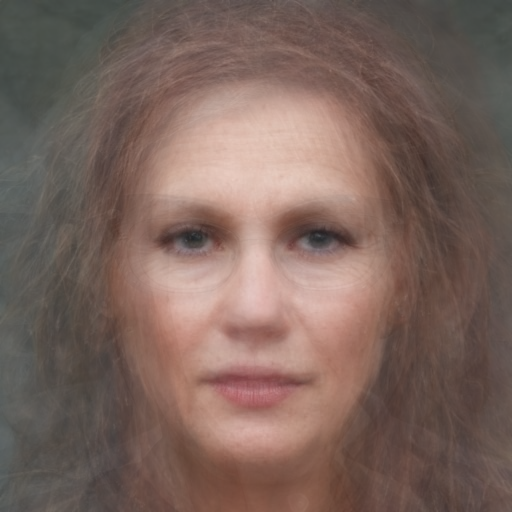

In [4]:
from composite.composite_generator import generate_composite

# Composite parameters
gender_filter = "female"
ethnicity_filter = "white"
age_filter = None
attractiveness_filter = [0.0, 10.0]  # deciled scores 1-10
sample_size = 25

img = generate_composite(
    df=attributes_final,
    gender=gender_filter,
    ethnicity=ethnicity_filter,
    age_range=age_filter,
    attractiveness=attractiveness_filter,   # replaces attr_min, attr_max
    sample_size=sample_size,
    verbose=True
)
img


In [ ]:
from pathlib import Path
from composite.composite_generator import filter_faces
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reload full score table to access raw predictions for percentile
scores_full = pd.read_parquet(ATTR_SCORES) if Path(ATTR_SCORES).exists() else None

filtered = filter_faces(
    attributes_final,
    gender=gender_filter,
    ethnicity=ethnicity_filter,
    age_range=age_filter,
    attractiveness=attractiveness_filter,
    min_results=12,
    verbose=True,
)

sample_n = min(sample_size, len(filtered))
sampled = filtered.sample(sample_n, random_state=42) if sample_n > 0 else filtered

if sample_n > 0 and scores_full is not None:
    sample_scores = scores_full.merge(sampled[['filename']], on='filename', how='inner')
    if not sample_scores.empty and 'attractiveness_raw' in sample_scores.columns:
        mean_attr = float(sample_scores['attractiveness_raw'].mean())
        median_attr = float(sample_scores['attractiveness_raw'].median())
        pct = float((scores_full['attractiveness_raw'] <= mean_attr).mean())
        comp_decile = int(np.clip(np.ceil(pct * 10), 1, 10))
        print(f'Composite attractiveness vs dataset — raw_mean={mean_attr:.4f}, percentile={pct*100:.1f}%, decile={comp_decile}')
        print(sample_scores['attractiveness'].value_counts().sort_index())
    elif not sample_scores.empty and 'attractiveness' in sample_scores.columns:
        mean_attr = float(sample_scores['attractiveness'].mean())
        median_attr = float(sample_scores['attractiveness'].median())
        pct = float((scores_full['attractiveness'] <= mean_attr).mean())
        comp_decile = int(np.clip(np.ceil(pct * 10), 1, 10))
        print(f'Composite attractiveness vs dataset — decile_mean={mean_attr:.2f}, percentile={pct*100:.1f}%, decile={comp_decile}')
        print(sample_scores['attractiveness'].value_counts().sort_index())
    else:
        mean_attr = median_attr = comp_decile = None
        print('No attractiveness columns available in scores; run inference with raw outputs.')
else:
    mean_attr = median_attr = comp_decile = None
    print('attractiveness column missing or no samples; ensure scores are available.')

if 'img' in locals():
    title_text = 'Composite'
    if comp_decile is not None:
        title_text = f"Composite (dataset decile={comp_decile}, mean_raw={mean_attr:.4f})"
    elif mean_attr is not None:
        title_text = f"Composite (mean={mean_attr:.2f}, median={median_attr:.2f})"
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title_text)
    plt.show()


In [5]:
import pandas as pd

ATTR_PATH = 'data/processed/metadata/attributes_final.parquet'
ATTR_SCORES = 'data/processed/metadata/attractiveness_scores.parquet'
ATTR_META = 'data/processed/metadata/attributes_with_meta.parquet'

attributes_final = pd.read_parquet(ATTR_PATH)

# Merge model attractiveness scores
try:
    df_scores = pd.read_parquet(ATTR_SCORES)
    attributes_final = attributes_final.merge(
        df_scores[['filename', 'attractiveness']],
        on='filename',
        how='left',
        suffixes=('', '_model')
    )
    if 'attractiveness_model' in attributes_final.columns:
        if 'attractiveness' in attributes_final.columns:
            attributes_final['attractiveness'] = attributes_final['attractiveness'].fillna(
                attributes_final['attractiveness_model']
            )
        else:
            attributes_final['attractiveness'] = attributes_final['attractiveness_model']
        attributes_final = attributes_final.drop(columns=['attractiveness_model'])
except FileNotFoundError:
    print(f'Missing {ATTR_SCORES}; run attractiveness inference first.')

# Optional geometry-based attractiveness
try:
    df_meta = pd.read_parquet(ATTR_META)
    if 'attractiveness_geom' in df_meta.columns:
        attributes_final = attributes_final.merge(df_meta[['filename','attractiveness_geom']], on='filename', how='left')
except FileNotFoundError:
    pass

attributes_final.head()


,filename,age,gender_final,ethnicity_final,attractiveness,attractiveness_geom
0,SFHQ_pt4_00086092.jpg,None,unknown,unknown,8,6.0
1,SFHQ_pt4_00065309.jpg,None,female,unknown,7,6.0
2,SFHQ_pt4_00062466.jpg,None,unknown,unknown,2,9.0
3,SFHQ_pt4_00090828.jpg,None,unknown,unknown,4,9.0
4,SFHQ_pt4_00032251.jpg,None,unknown,unknown,5,4.0


In [6]:
df = attributes_final  # your loaded metadata

print("Gender counts:")
display(df["gender_final"].value_counts(dropna=False))

print("\nEthnicity counts:")
display(df["ethnicity_final"].value_counts(dropna=False))

print("\nAge stats:")
display(df["age"].describe())


Gender counts:


gender_final
unknown    7164
male       1730
female     1106
Name: count, dtype: int64


Ethnicity counts:


ethnicity_final
unknown                    7846
white                      1244
black                       267
latino/hispanic             230
east_or_southeast_asian     196
middle_eastern              118
indian                       99
Name: count, dtype: int64


Age stats:


count       0
unique      0
top       NaN
freq      NaN
Name: age, dtype: object